# Breast Cancer Diagnostics

### Supervised learning potpourri

This challenge is to predict breast cancer based on biopsy data.  I started this model for the 3.2.6_RandomForest challenge and will be building off of it.

>#### Random Forest Challenge

>We will be comparing the accuracy and speed of a single decision tree vs. a random forest. The challenge here is to make the most accurate decision tree possible and compare it to the simplest random forest possible.

>For this exercise we will be using the popular [Wisconsin Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29).  Our goal will be to predict malignant tumors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import time

In [2]:
cancer = pd.read_csv('breast-cancer-wisconsin.data.txt', na_values='?')
cancer.columns = ['sample', 
                  'clump_thickness', 
                  'cell_size_uni', 
                  'cell_shape_uni', 
                  'marginal_adhesion',
                  'single_epi_cell_size',
                  'bare_nuclei',
                  'bland_chromatin',
                  'normal_nucleoli',
                  'mitoses',
                  'class']
cancer.dropna(inplace=True)

In [3]:
cancer.head()

,sample,clump_thickness,cell_size_uni,cell_shape_uni,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1002945,5,4,4,5,7,10.0,3,2,1,2
1,1015425,3,1,1,1,2,2.0,3,1,1,2
2,1016277,6,8,8,1,3,4.0,3,7,1,2
3,1017023,4,1,1,3,2,1.0,3,1,1,2
4,1017122,8,10,10,8,7,10.0,9,7,1,4


In [4]:
cancer.describe()

,sample,clump_thickness,cell_size_uni,cell_shape_uni,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.820000e+02,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,1.076833e+06,4.441349,3.153959,3.218475,2.832845,3.236070,3.548387,3.445748,2.872434,1.604106,2.700880
std,6.210926e+05,2.822751,3.066285,2.989568,2.865805,2.224214,3.645226,2.451435,3.054065,1.733792,0.954916
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.774540e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171820e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238741e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [5]:
cancer['class'].value_counts()

2    443
4    239
Name: class, dtype: int64

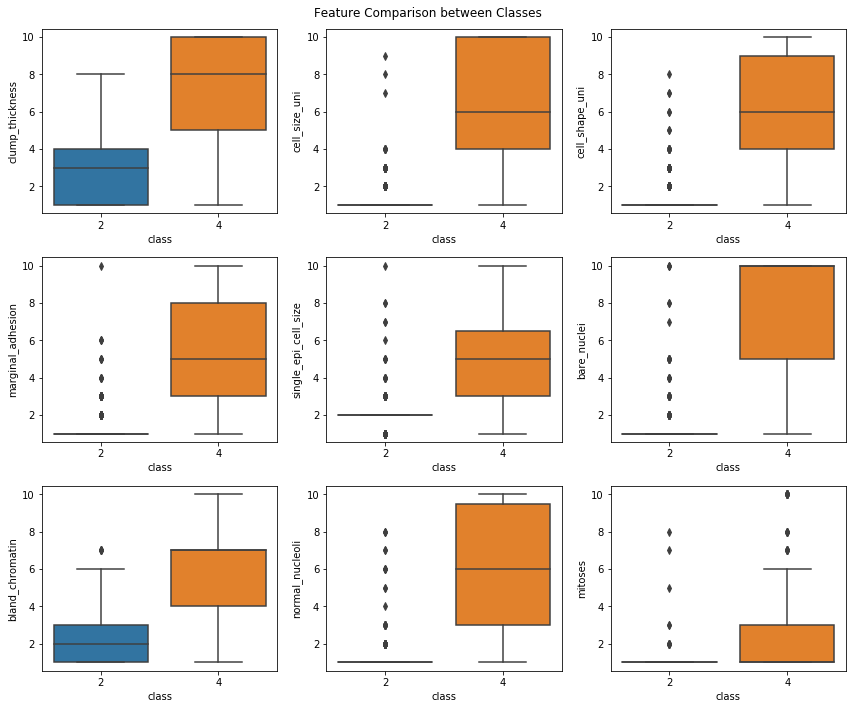

In [6]:
columns = cancer.columns[1:-1]

plt.figure(figsize=(12,10))
plt.suptitle('Feature Comparison between Classes')

for col in enumerate(columns):
    plt.subplot(3,3,(col[0]+1))
    sns.boxplot(data=cancer, y=col[1], x='class')
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Data description

We have 698 samples here and no missing data. The target variable is `class` where 2 == benign tumor and 4 == malignant tumor.  There is a class imbalance present, with malignant tumors only representing 34% of the total dataset.


### OHE and Data Augmentation

We will up-sample the malignant class to create a balanced data set, then we will OHE all the features.  Finally, we'll do the train/test split.

In [7]:
# Up-sampling the minority class
from sklearn.utils import resample

# Breaking out the data into minority and majority dataframes
majority_df = cancer[cancer['class'] == 2]
minority_df = cancer[cancer['class'] == 4]

minority_upsampled_df = resample(minority_df,
                               replace = True,
                               n_samples = 443)

upsampled_df = pd.concat([majority_df, minority_upsampled_df])

upsampled_df['class'].value_counts()

4    443
2    443
Name: class, dtype: int64

In [8]:
X_variables = upsampled_df.iloc[:, 1:10]

# One hot encoding the variables
def onehot(df, cols):
    for c in cols:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

X_col = X_variables.columns
X = onehot(X_variables, X_col)
X = X.iloc[:,9:]
Y = upsampled_df['class'].replace(to_replace={4:1, 2:0})


In [9]:
print(X.shape)
X.head()

(886, 89)


,clump_thickness_1,clump_thickness_2,clump_thickness_3,clump_thickness_4,clump_thickness_5,clump_thickness_6,clump_thickness_7,clump_thickness_8,clump_thickness_9,clump_thickness_10,...,normal_nucleoli_10,mitoses_1,mitoses_2,mitoses_3,mitoses_4,mitoses_5,mitoses_6,mitoses_7,mitoses_8,mitoses_10
0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=150)

# Logistic Regression

This is a binary classification problem, so logistic regression is a good first model choice.  We'll run a vanilla regression and a small range of ridge & lasso regressions.

In [11]:
from sklearn.linear_model import LogisticRegression

# Vanilla logistic regression with C=1e6 to approximate the linear solution
logr = LogisticRegression(solver='liblinear', C=1e6, random_state=150)
logr.fit(X_train, Y_train)
print('LogR Train Score: ', logr.score(X_train, Y_train))
print('LogR Test Score: ', logr.score(X_test, Y_test))


# Ridge regression with varying C
c_range = [.01, .1, .25, .35, .5, .65, .75, .9, 1]

print('\nSample\tC\tRidge Score')
for c in c_range:
    ridger = LogisticRegression(solver = 'liblinear', 
                                penalty = 'l2', 
                                random_state = 150,
                                C=c)
    ridger.fit(X_train, Y_train)
    print(f'tr\t{c}\t{ridger.score(X_train, Y_train)}')
    print(f'T\t{c}\t{ridger.score(X_test, Y_test)}')


# Lasso regression with varying C
print('\nSample\tC\tLasso Score')
for c in c_range:
    lassor = LogisticRegression(solver = 'liblinear',
                                penalty = 'l1',
                                random_state = 150,
                                C=c)
    lassor.fit(X_train, Y_train)
    print(f'tr\t{c}\t{lassor.score(X_train, Y_train)}')
    print(f'T\t{c}\t{lassor.score(X_test, Y_test)}')

LogR Train Score:  1.0
LogR Test Score:  0.963963963963964

Sample	C	Ridge Score
tr	0.01	0.9728915662650602
T	0.01	0.963963963963964
tr	0.1	0.983433734939759
T	0.1	0.963963963963964
tr	0.25	0.9864457831325302
T	0.25	0.972972972972973
tr	0.35	0.9894578313253012
T	0.35	0.972972972972973
tr	0.5	0.9894578313253012
T	0.5	0.972972972972973
tr	0.65	0.9894578313253012
T	0.65	0.9774774774774775
tr	0.75	0.9894578313253012
T	0.75	0.9774774774774775
tr	0.9	0.9909638554216867
T	0.9	0.9774774774774775
tr	1	0.9909638554216867
T	1	0.9774774774774775

Sample	C	Lasso Score
tr	0.01	0.516566265060241
T	0.01	0.45045045045045046
tr	0.1	0.9683734939759037
T	0.1	0.9504504504504504
tr	0.25	0.9743975903614458
T	0.25	0.9504504504504504
tr	0.35	0.9804216867469879
T	0.35	0.9594594594594594
tr	0.5	0.983433734939759
T	0.5	0.963963963963964
tr	0.65	0.983433734939759
T	0.65	0.9684684684684685
tr	0.75	0.9849397590361446
T	0.75	0.9684684684684685
tr	0.9	0.9864457831325302
T	0.9	0.9684684684684685
tr	1	0.9864457831325302

Vanilla logistic regression seems over fit because it perfectly describes the training data.  Both Ridge and Lasso appear to land on similar solutions, with test scores equal to ~0.973.  However, in each set of models we see varying (but always small) amounts of overfit.  The model with the most equally explained variance between the training and test data is **Ridge (C=0.5)**.  Let's check out the confusion matrices and recall of the best models.

In [12]:
# Confusion matrix & recall of vanilla logistic model
logr_pred = logr.predict(X_test)
logr_confmx = pd.crosstab(Y_test, logr_pred)
logr_recall = (logr_confmx[1][1] / (logr_confmx[0][1] + logr_confmx[1][1]))
print('Vanilla Logistic recall: ', logr_recall)
print('\nVanilla Logistic Conf MX:')
print(logr_confmx)

# Re-instantiating the best ridge model to get the confusion matrix & recall
ridger = LogisticRegression(solver = 'liblinear', 
                            penalty = 'l2', 
                            C=0.5)
ridger.fit(X_train, Y_train)
ridger_pred = ridger.predict(X_test)
ridger_confmx = pd.crosstab(Y_test, ridger_pred)
ridger_recall = (ridger_confmx[1][1] / (ridger_confmx[0][1] + ridger_confmx[1][1]))
print('\n\nRidge recall: ', ridger_recall)
print('\nRidge Logistic Conf MX:')
print(ridger_confmx)


Vanilla Logistic recall:  0.9672131147540983

Vanilla Logistic Conf MX:
col_0   0    1
class         
0      96    4
1       4  118


Ridge recall:  0.9918032786885246

Ridge Logistic Conf MX:
col_0   0    1
class         
0      95    5
1       1  121


The ridge model does, indeed, perform better.  


# Random Forest and Boosted Trees

While we have very good results with the logistic models, perhaps an esemble approach can do better.  The caveat here is that we will lose most of our explanatory power.  But, given that we are trying to predict cancer, it's probably best to maximize the recall and eschew complete explanatory power.

In [13]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500, 
                             criterion='entropy')
rfc.fit(X_train, Y_train)
rfc_pred = rfc.predict(X_test)

# Confusion matrix and recall
rfc_confmx = pd.crosstab(Y_test, rfc_pred)
rfc_recall = (rfc_confmx[1][1] / (rfc_confmx[0][1] + rfc_confmx[1][1]))

print('Random Forest recall: ', rfc_recall)
print('\nRandom Forest Conf MX:')
print(rfc_confmx)

Random Forest recall:  1.0

Random Forest Conf MX:
col_0   0    1
class         
0      95    5
1       0  122


A simple random forest model actually correctly classified all the true positives!  It didn't do any better in the false positive category though.  Let's check out a Gradient Boosting Classifier to see if we can make gains there.

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=1000,
                                 loss='deviance',
                                 learning_rate=.1,
                                 subsample=.25, 
                                 max_depth=3)
gbc.fit(X_train, Y_train)
gbc_pred = gbc.predict(X_test)

# Confusion matrix and recall
gbc_confmx = pd.crosstab(Y_test, gbc_pred)
gbc_recall = (gbc_confmx[1][1] / (gbc_confmx[0][1] + gbc_confmx[1][1]))

print('Gradient Boosting recall: ', gbc_recall)
print('\nGradient Boosting Conf MX:')
print(gbc_confmx)

Gradient Boosting recall:  1.0

Gradient Boosting Conf MX:
col_0   0    1
class         
0      95    5
1       0  122


It doesn't seem like we can do better than that.